In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from utils import plot_all_metrics
import os
import warnings
warnings.filterwarnings('ignore')

# Carga de Datos

In [ ]:
# Directorio base
base_dir = os.path.join('..','data', 'train_test_val')

# Cargar los DataFrames
train = pd.read_csv(os.path.join(base_dir, 'train.csv'))
test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
val = pd.read_csv(os.path.join(base_dir, 'val.csv'))

# Escalado con Standard Scaler

In [ ]:

# Separamos las características (X) y target (y)
X_train = train.drop(columns=['income'])
y_train = train['income']
X_val = val.drop(columns=['income'])
y_val = val['income']
X_test = test.drop(columns=['income'])
y_test = test['income']

# Escalamos características (solo se ajusta con el train)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Entrenamos el Modelo LightGBM

In [ ]:
# Configuramos el modelo
model = LGBMClassifier(
    random_state=42,
    verbose=1,
)

# Entrenamos con early stopping
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='binary_logloss',
    callbacks=[early_stopping(stopping_rounds=50)],
)

[LightGBM] [Info] Number of positive: 7961, number of negative: 25170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 729
[LightGBM] [Info] Number of data points in the train set: 33131, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240289 -> initscore=-1.151098
[LightGBM] [Info] Start training from score -1.151098
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.265829


LGBMClassifier(random_state=42, verbose=1)

Implementamos un early stopping con 50 rondas para evitar el sobreajuste, utilizando el conjunto de validación para monitorear el rendimiento. 

El modelo alcanzó su mejor iteración en la ronda 97 con un binary_logloss de 0.265829 en el conjunto de validación.

# Evaluacion y Graficas Metricas

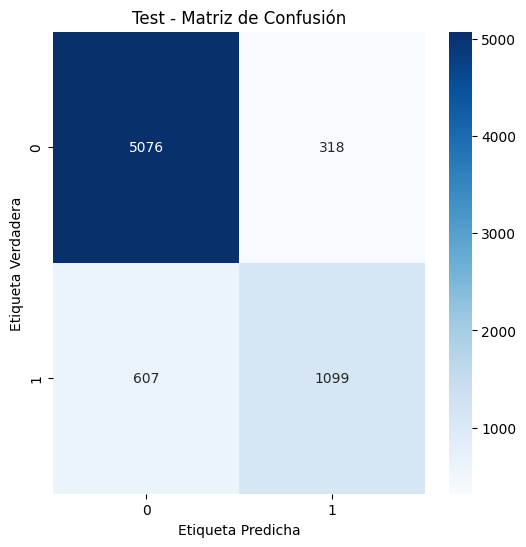

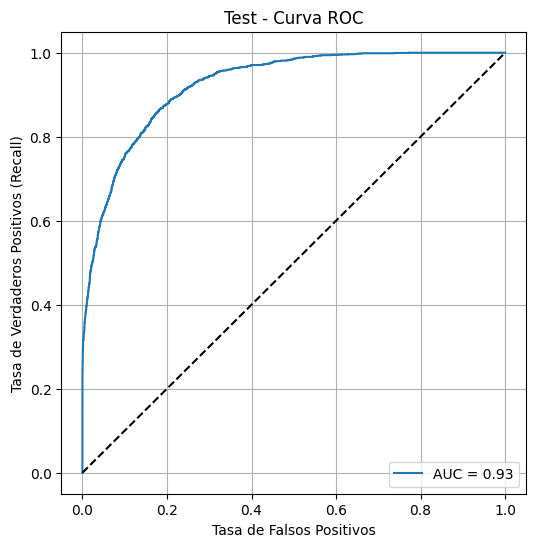

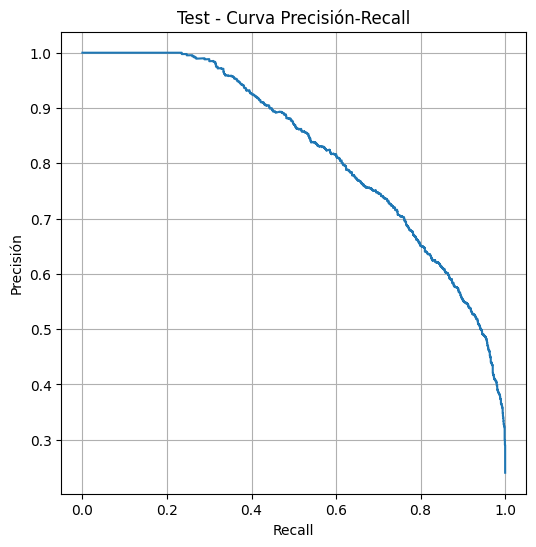

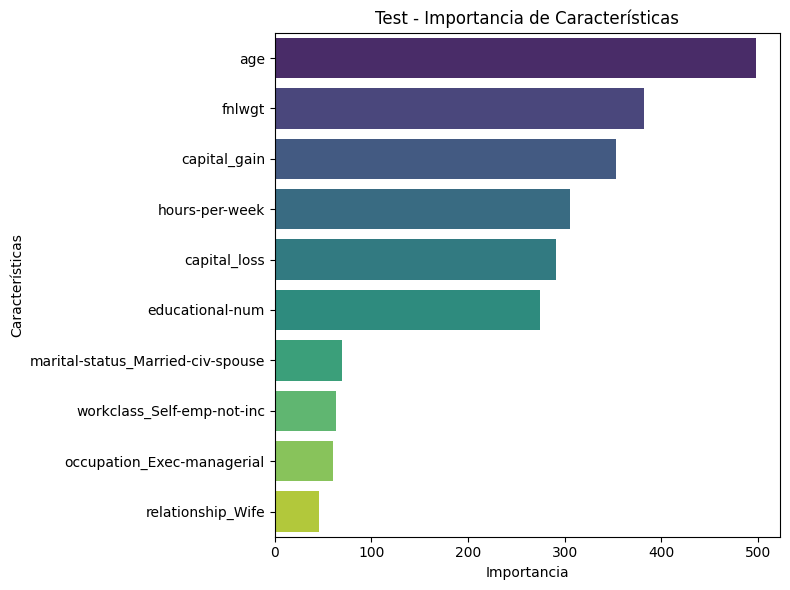

In [ ]:
# Predecimos en el conjunto de prueba
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Generamos gráficas
plot_all_metrics(
    y_true=y_test,
    y_pred=y_pred,
    model=model,
    x_features=X_test_scaled,
    dataset_name='Test',
    feature_names=X_test_scaled.columns.tolist()
)

# Conclusiones y Analisis

**Analizando la matriz de confusion, podemos observar:**

* Verdaderos Negativos (TN): El modelo ha identificado correctamente un gran número de casos donde los individuos tienen ingresos bajos (≤50K).

* Falsos Positivos (FP): Hay un número significativo de casos donde el modelo predijo incorrectamente ingresos altos cuando en realidad eran bajos.

* Falsos Negativos (FN): También existen casos donde el modelo predijo ingresos bajos cuando en realidad eran altos.

* Verdaderos Positivos (TP): El modelo ha acertado en identificar correctamente a personas con ingresos altos (>50K).

La precisión global del modelo es aceptable, pero hay margen de mejora especialmente en la identificación de personas con ingresos altos, donde parece haber más dificultad para clasificar correctamente.

**Este gráfico de métricas de rendimiento proporciona una visión completa de cómo se comporta el modelo según diferentes criterios:**

* Accuracy (Exactitud): Indica el porcentaje total de predicciones correctas. El modelo muestra una exactitud relativamente alta, lo que sugiere un buen rendimiento general.

* Precision (Precisión): Mide la proporción de predicciones positivas que son realmente correctas. Una precisión moderada indica que cuando el modelo predice ingresos altos, acierta en un porcentaje aceptable de casos.

* Recall (Sensibilidad): Representa la proporción de casos positivos reales que fueron correctamente identificados. El valor de recall sugiere que el modelo tiene cierta dificultad para identificar todos los casos de ingresos altos.

* F1-Score: Es la media armónica entre precisión y recall. El valor de F1 muestra un equilibrio razonable entre ambas métricas.

* ROC AUC: Mide la capacidad del modelo para distinguir entre clases. Un valor cercano a 1 indica un buen poder discriminativo.

En general, estas métricas sugieren que el modelo tiene un rendimiento sólido pero con espacio para mejoras, especialmente en términos de recall para la clase minoritaria (ingresos altos).

**La curva ROC (Receiver Operating Characteristic) ilustra el rendimiento del clasificador en todos los umbrales de clasificación posibles:**

* El área bajo la curva ROC (AUC) es significativamente mayor que 0.5 (que representaría un clasificador aleatorio), lo que indica que el modelo tiene un buen poder predictivo.

* La forma de la curva muestra que el modelo logra un buen equilibrio entre la tasa de verdaderos positivos y la tasa de falsos positivos en varios umbrales.

**La distribución de probabilidades muestra cómo el modelo asigna probabilidades a las diferentes clases:**

* Se observa una clara separación entre las distribuciones de probabilidades para las clases positiva y negativa, lo que es indicativo de un modelo con buena capacidad discriminativa.

* Sin embargo, hay cierto solapamiento entre ambas distribuciones, lo que explica los errores de clasificación observados en la matriz de confusión.

Esta visualización confirma que el modelo tiene una capacidad razonable para distinguir entre personas con ingresos altos y bajos, aunque con algunas limitaciones en casos límite.

**Conclusión sobre la Importancia de las Características:**

El gráfico de importancia de características revela que las variables más influyentes para el modelo son principalmente continuas, como la
* **Edad (age)**
* **El peso final (fnlwgt)**
* **Las ganancias de capital (capital_gain).**

Estas características tienen un impacto significativo en la capacidad del modelo para predecir el ingreso.

Por otro lado, las variables categóricas como:
* **El estado civil (marital-status_Married-civ-spouse)**
* **La ocupación (occupation_Exec-managerial)** 

también contribuyen, aunque en menor medida, lo que sugiere que las relaciones sociales y el tipo de empleo tienen cierta relevancia en la predicción.

En general, el modelo parece depender más de características numéricas relacionadas con la economía y el tiempo trabajado, mientras que las características categóricas tienen un impacto secundario. Esto podría indicar que los ingresos están más fuertemente correlacionados con factores económicos y demográficos que con aspectos sociales o laborales específicos.